# 1. Исследовательский анализ данных

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt


In [5]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [6]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [7]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
len(train_gen_flow)

238

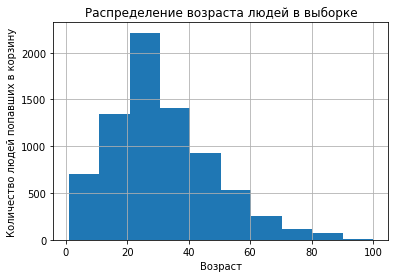

In [9]:
plt.hist(labels['real_age'])
plt.title("Распределение возраста людей в выборке")
plt.xlabel("Возраст")
plt.ylabel("Количество людей попавших в корзину")
plt.grid()
plt.show()

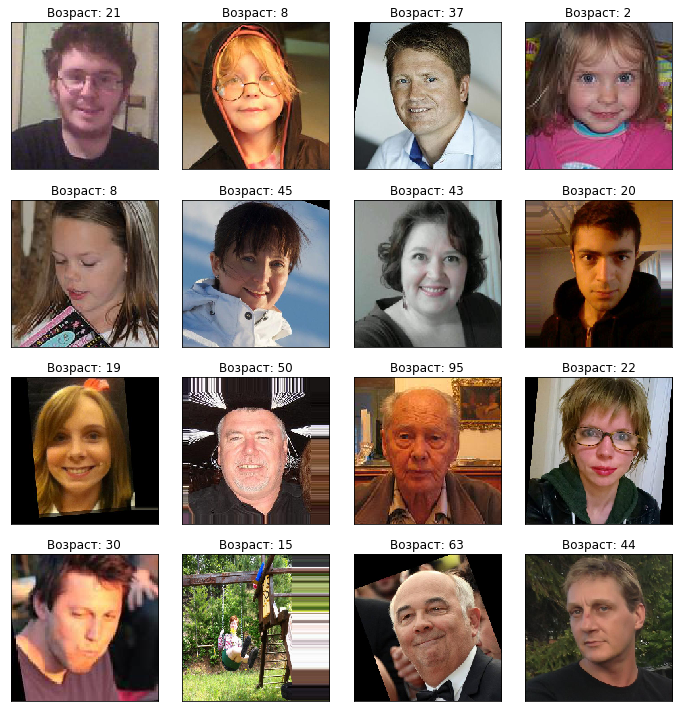

In [16]:
features, target = next(train_gen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.title("Возраст: {:}".format(target[i]))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Вывод
* Распределение людей по возрастам не равномерное, я имею ввиду что если бы мы проводили классификацию на 3 класса взрослые, пожилые и дети то был бы дисбаланс этих классов.
* В датасете присутсвуют цветные и чб изображения.


# 2. Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       #rotation_range=90,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2
                                       )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory= path + '/final_files/',
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(224, 224), 
                                                          batch_size=32,
                                                          class_mode='raw',
                                                          #subset='training',
                                                          seed=12345        )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       #rotation_range=90,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2
                                       )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        #subset='testing',
        seed=12345
        )

    return test_datagen_flow
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)#0.0001
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer,
                  loss='mae',
                  metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          batch_size=batch_size,
          verbose=2, epochs=epochs)

    return model 
```

ИЗМЕНЕНИЯ:
1. УБРАН ВЕРТИКАЛЬНЫЙ ФЛИП
2. ДОБАВЛЕНА ВАЛИДАЦИЯ В ОБУЧАЮЩИЙ ImageDataGenerator
3. УДАЛЕНА АУГМЕНТАЦИЯ В ДЛЯ ТЕСТОВОЙ ВЫБОРКИ. ТЕПЕРЬ ПРИМЕНЯЕТСЯ ТОЛЬКО ДЛЯ ТРЕНИРОВОЧНОЙ ЧАСТИ ДАННЫХ

```

# < скопируйте результат вывода на экран сюда >
# < длинные строки со скачиванием модели можно удалить >

Train for 238 steps, validate for 238 steps
Epoch 1/10
2021-01-13 06:43:19.446581: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-13 06:43:19.760125: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 93s - loss: 10.7122 - mae: 10.7043 - val_loss: 23.9545 - val_mae: 24.0016
Epoch 2/10
238/238 - 86s - loss: 7.7995 - mae: 7.7869 - val_loss: 17.2121 - val_mae: 17.2472
Epoch 3/10
238/238 - 84s - loss: 7.0313 - mae: 7.0124 - val_loss: 9.4228 - val_mae: 9.4300
Epoch 4/10
238/238 - 85s - loss: 6.4833 - mae: 6.4561 - val_loss: 7.8319 - val_mae: 7.8397
Epoch 5/10
238/238 - 85s - loss: 6.1200 - mae: 6.1052 - val_loss: 7.5351 - val_mae: 7.5390
Epoch 6/10
238/238 - 85s - loss: 5.6356 - mae: 5.6210 - val_loss: 5.8805 - val_mae: 5.8791
Epoch 7/10
238/238 - 85s - loss: 5.3853 - mae: 5.3724 - val_loss: 5.6602 - val_mae: 5.6672
Epoch 8/10
238/238 - 84s - loss: 5.0640 - mae: 5.0538 - val_loss: 5.1233 - val_mae: 5.1255
Epoch 9/10
238/238 - 85s - loss: 4.8477 - mae: 4.8394 - val_loss: 4.7665 - val_mae: 4.7723
Epoch 10/10
238/238 - 84s - loss: 4.7436 - mae: 4.7247 - val_loss: 4.8525 - val_mae: 4.8541
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 41s - loss: 4.8331 - mae: 4.8391
Test MAE: 4.8391

```


### новый исправленный код
```
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25,# ДОБАВЛЕНА ВАЛИДАЦИЯ В ОБУЧАЮЩИЙ ImageDataGenerator
                                       rescale=1./255,
                                       horizontal_flip=True,
                                       #vertical_flip=True, # УБРАН ВЕРТИКАЛЬНЫЙ ФЛИП
                                       #rotation_range=90,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2
                                       )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
                                                          directory= path + '/final_files/',
                                                          x_col='file_name',
                                                          y_col='real_age',
                                                          target_size=(224, 224), 
                                                          batch_size=32,
                                                          class_mode='raw',
                                                          #subset='training',
                                                          seed=12345        )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(
                                       rescale=1./255,
                                       #horizontal_flip=True, # УДАЛЕНА АУГМЕНТАЦИЯ В ДЛЯ ТЕСТОВОЙ ВЫБОРКИ
                                       #vertical_flip=True,
                                       #rotation_range=90,
                                       #width_shift_range=0.2,
                                       #height_shift_range=0.2
                                       )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        #subset='testing',
        seed=12345
        )

    return test_datagen_flow
def create_model(input_shape):
    optimizer = Adam(lr=0.0001)#0.0001
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.compile(optimizer=optimizer,
                  loss='mse',
                  metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
          validation_data=test_data,
          steps_per_epoch=steps_per_epoch,
          validation_steps=validation_steps,
          batch_size=batch_size,
          verbose=2, epochs=epochs)

    return model 
```

### результат обучения
```
Train for 238 steps, validate for 238 steps
Epoch 1/10
2021-01-14 08:54:43.841894: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-14 08:54:48.274655: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
238/238 - 178s - loss: 190.9798 - mae: 9.8353 - val_loss: 851.7108 - val_mae: 24.2519
Epoch 2/10
238/238 - 86s - loss: 72.0690 - mae: 6.3664 - val_loss: 383.0088 - val_mae: 14.4485
Epoch 3/10
238/238 - 85s - loss: 48.7667 - mae: 5.2435 - val_loss: 108.3805 - val_mae: 7.7219
Epoch 4/10
238/238 - 85s - loss: 36.3224 - mae: 4.5558 - val_loss: 45.6629 - val_mae: 5.1884
Epoch 5/10
238/238 - 86s - loss: 28.7742 - mae: 4.0821 - val_loss: 21.8157 - val_mae: 3.5182
Epoch 6/10
238/238 - 86s - loss: 22.0853 - mae: 3.5477 - val_loss: 43.1716 - val_mae: 5.4054
Epoch 7/10
238/238 - 86s - loss: 20.1128 - mae: 3.3876 - val_loss: 22.2848 - val_mae: 3.6608
Epoch 8/10
238/238 - 84s - loss: 15.7652 - mae: 3.0104 - val_loss: 15.9300 - val_mae: 3.0184
Epoch 9/10
238/238 - 84s - loss: 13.4063 - mae: 2.7414 - val_loss: 31.1509 - val_mae: 4.4900
Epoch 10/10
238/238 - 86s - loss: 10.5545 - mae: 2.4619 - val_loss: 15.7786 - val_mae: 2.9975
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
238/238 - 42s - loss: 15.7786 - mae: 2.9975
Test MAE: 2.9975
```

# 3. Анализ обученной модели

* Модель обучалась быстро по сравнению с другими моделями в этом спринте
* Код модели получился весьма наглядным и простым
* MAE оказалось достаточно низким, возможно это связано с маленьким lr в оптимайзере Adam

*дополненный анализ*
* test MAE оказалась равна 2.9975, но посчитана она не совсем корректно так как я применил(зря) аугментацию к тестовому набору данных.
* Параметры: данная модель построена на основе ResNet50 без её родной верхушки. Вместо неё добавлен 1 нейрон с активацией Relu. В качестве оптимайзера использован алгоритм Adam с lr=0.0001. В качестве функции потерь в последем варинате модели использовано mse. На обучение одной эпохи уходит примерно 86 секунд.
* Данная модель позволяет решать одну из поставленных задач предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, и не позволяет контролировать добросовестность кассиров при продаже алкоголя, так как её точность(test mae) равна ~ +- 3 года. Это приведет к ошибкам (как много это уже другой вопрос) в работе данного сервиса для людей 15-21 лет. 